In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
df_imdb = pd.read_csv("imdb_small.csv")

In [4]:
df_imdb=df_imdb.set_index("Unnamed: 0")

In [5]:
df_imdb.head()

,text,sentiment
Unnamed: 0,,
0,*****Warning: May contain SPOILERS********* My...,1
1,He really lost the plot with this one! None of...,1
2,"Hello everyone, This is my first time posting ...",0
3,On his birthday a small boys tells his mother ...,1
4,I love this show as it action packed with adve...,0


In [6]:
df_imdb['sentiment'].value_counts()

1    600
0    600
Name: sentiment, dtype: int64

In [7]:
df = df_imdb.sample(frac=1)

In [8]:
df.head()

,text,sentiment
Unnamed: 0,,
195,I normally have no problem walking away from a...,1
1162,Eye in the Labyrinth is not your average Giall...,0
101,0.5/10. This movie has absolutely nothing good...,1
792,I was able to watch this movie in its entirety...,0
949,"If you like film, don't miss this one. If you ...",0


In [9]:
numbers=list(df['sentiment'].unique())
list_zeros = [0]*len(numbers)
count_dictionary = dict(zip(numbers, list_zeros))

values_array_train=[]
values_array_test=[]
values_array_unlabelled=[]
for index, row in df.iterrows():
    if count_dictionary[row['sentiment']]<20:
        count_dictionary[row['sentiment']]=count_dictionary[row['sentiment']]+1
        values_array_train.append((row['text'],row['sentiment']))
    elif count_dictionary[row['sentiment']]<60:
        count_dictionary[row['sentiment']]=count_dictionary[row['sentiment']]+1
        values_array_test.append((row['text'],row['sentiment']))
    elif count_dictionary[row['sentiment']]<600:
        count_dictionary[row['sentiment']]=count_dictionary[row['sentiment']]+1
        values_array_unlabelled.append((row['text'],'UNK'))

In [10]:
print(len(values_array_train))

40


In [11]:
print(len(values_array_test))

80


In [12]:
print(len(values_array_unlabelled))

1080


In [13]:
print(values_array_train[0])

("I normally have no problem walking away from a bad movie, however this was an unique case. This movie was so bad that I actually sat through the whole thing almost praying it would have one minute of good movie time to justify the hour and a half that was wasted. Needless to say I was brutally disappointed. Set at a beach house where a group of college friends are celebrating vacation, this movie suffers from numerous problems making it not worth seeing. First, there are gaping plot holes. Second, very few of the C-list (i don't even dare call them B) actors can act worth a damn, so any scenes that have potential fail miserably. Third, the rate of the film is very choppy and awkward to watch most of the time making suspense building very difficult, leading to very few surprises for the audience. Fourth and most importantly, the ending is completely anti-climatic partially because of how it ends (setting/who the killer turns out to be) and partially because the dialog is just atrociou

In [14]:
print(values_array_test[0])

('I read several mixed reviews and several of them downright trashed the movie. I originally became interested in this project because it was being directed by Tony Scott and I have become very interested in his work after Man On Fire had such a profound impact on me. Before I start my review, let me first say this...it\'s wonderful to see that this movie could have been told in a boring and ordinary manner, yet the writers and Scott chose a different approach.  Plot:  Simply stated, it\'s not boring. Most Hollywood movies give \'tried and true\' plots that they know will connect with people, often ensuring the audiences acceptance of the film and creating a higher probability of profit. This plot was one of the more interesting ones I had seen in a while. Just for reference, I recently watched \'The Weather Man\' and \'Lord of War\' and while I will say that these movies are excellent, and I enjoyed them both tremendously, both the plots in these movies are boring and they are told ex

In [15]:
print(values_array_unlabelled[1])

("This was far and away the worst movie i've ever seen in my entire life. It was slow, boring, not scary, not funny, not dramatic, not entertaining.  Sarah Michelle Gellar was up to her old playbook of empty expressions of fright and shock. She couldn't sell her character nor could anyone else in the picture.  For those who thought the Grudge was 'kind of alright' then don't go see this unless you get enjoyment out of wasting your time and your life.  I saw this movie for free by the way so I don't want this to come across as a rant from a guy that lost 8 bucks on a terrible movie. It was free, it still sucked, I hated it.  Avoid.", 'UNK')


In [16]:
#!pip install transformers==4.3.2
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install sentencepiece

##Set random values
#seed_val = 42
seed_val = 27
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [17]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1080 Ti


In [18]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 300
batch_size = 20

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
#num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-5
#learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 30
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

#model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name="google/electra-large-discriminator"
#model_name="google/electra-small-discriminator"
#model_name="microsoft/deberta-v2-xxlarge"
#model_name="microsoft/deberta-v3-base"
model_name = "google/electra-base-discriminator"

#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
#! git clone https://github.com/crux82/ganbert

#  NOTE: in this setting 50 classes are involved
# labeled_file = "./ganbert/data/labeled.tsv"
# unlabeled_file = "./ganbert/data/unlabeled.tsv"
# test_filename = "./ganbert/data/test.tsv"

label_list = ['UNK',0,1]

In [19]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /home/harry/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transform

In [20]:
#Load the examples
labeled_examples = values_array_train
#unlabeled_examples = values_array_unlabelled
test_examples = values_array_test

In [21]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
# if unlabeled_examples:
#   train_examples = train_examples + unlabeled_examples
#   #The unlabeled (train) dataset is assigned with a mask set to False
#   tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
#   train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

In [23]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [24]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
#hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
#generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  #generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /home/harry/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transform

In [25]:
training_stats = []

accuracy_array=[]

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
#g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
#gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
#   scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
#                                            num_warmup_steps = num_warmup_steps)

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    transformer.train() 
    #generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)

        real_batch_size = b_input_ids.shape[0]
     
        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs.last_hidden_state[:,0,:]
        #hidden_states = model_outputs[-1]
        #print(hidden_states[0].size())
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        #noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        #gen_rep = generator(noise)
        #print("Length of generator output {}".format(len(gen_rep)))
        #print("Length of single generator output {}".format(len(gen_rep[0])))

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        #disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(hidden_states)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, real_batch_size)
        D_real_features = features_list[0]
        #D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, real_batch_size)
        D_real_logits = logits_list[0]
        #D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, real_batch_size)
        D_real_probs = probs_list[0]
        #D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
#         g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
#         g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
#         g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        #D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U #+ D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        #gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        #g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        #gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        #tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
          scheduler_d.step()
          #scheduler_g.step()

    # Calculate the average loss over all of the batches.
    #avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    #print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    #generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            #hidden_states = model_outputs[-1]
            hidden_states = model_outputs.last_hidden_state[:,0,:]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            #'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )
    
    accuracy_array.append(test_accuracy)


======== Epoch 1 / 30 ========
Training...

  Average training loss discriminator: 1.379
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.525
  Test Loss: 0.951
  Test took: 0:00:01

======== Epoch 2 / 30 ========
Training...

  Average training loss discriminator: 1.117
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.512
  Test Loss: 0.836
  Test took: 0:00:01

======== Epoch 3 / 30 ========
Training...

  Average training loss discriminator: 0.938
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.500
  Test Loss: 0.770
  Test took: 0:00:01

======== Epoch 4 / 30 ========
Training...

  Average training loss discriminator: 0.838
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.688
  Test Loss: 0.724
  Test took: 0:00:01

======== Epoch 5 / 30 ========
Training...

  Average training loss discriminator: 0.759
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.738
  Test Loss: 0.684
  Test took: 0:00:01

======== Epoch 6 / 

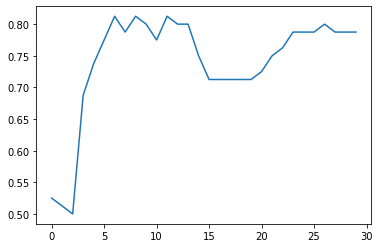

In [26]:
plt.plot(accuracy_array)

In [27]:
max(accuracy_array)

0.8125